# Import and Setup

In [3]:
import pandas as pd
import numpy as np
import json
import os
import re
from tqdm import tqdm
import pickle
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme(style="whitegrid")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from imblearn.over_sampling import RandomOverSampler

from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_hub as hub

# Load the Universal Sentence Encoder module
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed = hub.load(module_url)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jirayuwat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
TRAIN_PATH = r"train_for_student.json"
TEST_PATH = r"test_for_student.json"

TRAIN_PATH = os.path.join(os.path.pardir, "data", TRAIN_PATH)
TEST_PATH = os.path.join(os.path.pardir, "data", TEST_PATH)

LABEL_LIST = ['CE','ENV','BME','PE','METAL','ME','EE','CPE','OPTIC','NANO','CHE','MATENG','AGRI','EDU','IE','SAFETY','MATH','MATSCI']

# Preprocess

In [41]:
def clean_and_tokenize(df, is_test=False):
    df = df.copy()

    df['Text'] = df['Title'] + " " + df['Abstract']

    df.drop(columns=['Title', 'Abstract'], inplace=True)

    # lower case
    df['Text'] = df['Text'].apply(lambda x: x.lower())

    # remove special characters
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

    # remove single characters
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x))

    # remove text
    target_text = ['Published under licence by IOP Publishing Ltd', 'using', 'IEEE', 'Association for Computing Machinery', 'Elsevier', 'Springer']
    df['Text'] = df['Text'].apply(lambda x: re.sub('|'.join(target_text), '', x))

    # stemmer
    df['Text'] = df['Text'].apply(lambda x: ' '.join([nltk.PorterStemmer().stem(word) for word in x.split()]))

    # tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    
    df['Text'] = df['Text'].apply(lambda x: [word for word in word_tokenize(x)  if word not in stop_words])

    # word cloud
    all_words = [word for tokens in df['Text'] for word in tokens]
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(all_words))
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Top words after clean and tokenize')
    plt.axis('off')
    plt.show()

    return df

def sentences_2_vec(df):
    df = df.copy()

    eb = embed(df['Text'].apply(lambda x: ' '.join(x)))
    df['Text'] = eb.numpy().tolist()

    return df

def get_data(X, y, label, test_size=0.2, random_state=42, umsampling = True):
    X = np.array([np.array(x) for x in X['Text']])
    y = y.copy()[label]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # oversampling
    if umsampling:
        ros = RandomOverSampler(random_state=random_state)
        X_train, y_train = ros.fit_resample(X_train, y_train)

    return X_train, X_val, y_train, y_val

def load_data(path, has_label=True, vectorize=True):
    # load df
    data = json.load(open(path))

    # make df
    df = pd.DataFrame(data).transpose()

    # create labels
    if has_label:
        for idx, label in enumerate(LABEL_LIST):
            df[label] = df['Classes'].apply(lambda x: 1 if label in x else 0)
        df.drop(columns=['Classes'], inplace=True)

    # create X, y
    df = clean_and_tokenize(df, not has_label)
    if has_label:
        X = df.drop(columns=LABEL_LIST)
        if vectorize:
            X = sentences_2_vec(X)
        y = df[LABEL_LIST]
        return X, y
    else:
        if vectorize:
            df = sentences_2_vec(df)
        return np.array([np.array(x) for x in df['Text']])


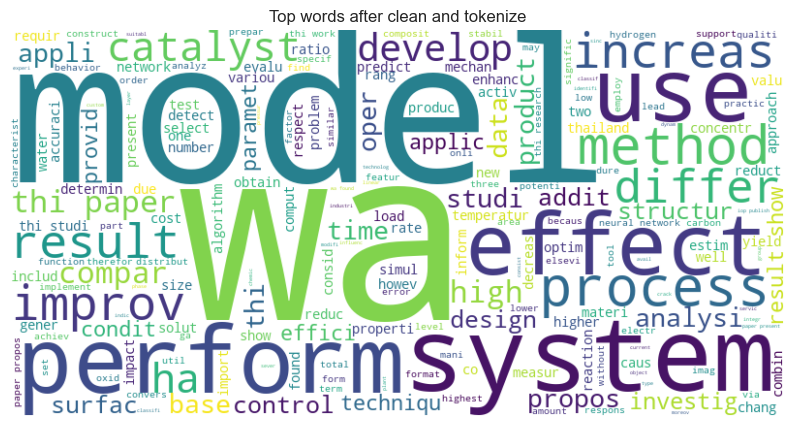

In [42]:
X_embedded, y = load_data(TRAIN_PATH, vectorize=True)

# Model

In [43]:
model_by_label = {}
avg_f1 = 0
for label in LABEL_LIST:
    # get data
    X_train, X_val, y_train, y_val = get_data(X_embedded, y, label, umsampling = False)
    
    # create model 
    model = SVC(kernel='linear', class_weight='balanced')
    model.fit(X_train, y_train)

    # evaluate
    y_pred = model.predict(X_val)
    clf_report = classification_report(y_val, y_pred, output_dict=True)
    avg_f1 += clf_report['1']['f1-score']
    print(f"Label: {label}")
    print(f"\tData shape: {X_train.shape}")
    print(f"\t1's class amount : {y_train.sum()}({y_train.sum()/len(y_train)*100:.2f}%)")
    print(f"\tf1-score: {clf_report['1']['f1-score']}")

    # save model
    model_by_label[label] = model

print(f"Average f1-score: {avg_f1 / len(LABEL_LIST)}")

# save models
with open("models.pkl", "wb") as f:
    pickle.dump(model_by_label, f)
print("Models saved")

Label: CE
	Data shape: (363, 512)
	1's class amount : 42(11.57%)
	f1-score: 0.46153846153846156
Label: ENV
	Data shape: (363, 512)
	1's class amount : 47(12.95%)
	f1-score: 0.5714285714285714
Label: BME
	Data shape: (363, 512)
	1's class amount : 29(7.99%)
	f1-score: 0.42857142857142855
Label: PE
	Data shape: (363, 512)
	1's class amount : 69(19.01%)
	f1-score: 0.6153846153846154
Label: METAL
	Data shape: (363, 512)
	1's class amount : 58(15.98%)
	f1-score: 0.5882352941176471
Label: ME
	Data shape: (363, 512)
	1's class amount : 72(19.83%)
	f1-score: 0.49056603773584906
Label: EE
	Data shape: (363, 512)
	1's class amount : 94(25.90%)
	f1-score: 0.631578947368421
Label: CPE
	Data shape: (363, 512)
	1's class amount : 114(31.40%)
	f1-score: 0.7076923076923077
Label: OPTIC
	Data shape: (363, 512)
	1's class amount : 25(6.89%)
	f1-score: 0.5333333333333333
Label: NANO
	Data shape: (363, 512)
	1's class amount : 26(7.16%)
	f1-score: 0.5
Label: CHE
	Data shape: (363, 512)
	1's class amount :

# Submission

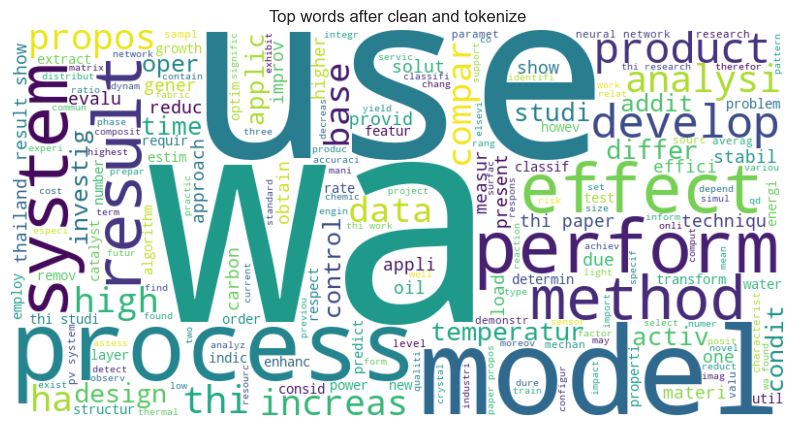

In [44]:
X_test = load_data(TEST_PATH, has_label=False)

In [45]:
X_test.shape

(151, 512)

In [46]:
submission_df = pd.DataFrame(columns= LABEL_LIST,
                             index= [f"{'0'*(3-len(str(k+1)))}{k+1}eval" for k in range(151)])

for label in LABEL_LIST:
    model = model_by_label[label]
    submission_df[label] = model.predict(X_test)

submission_df.index.name = "id"
submission_df

,CE,ENV,BME,PE,METAL,ME,EE,CPE,OPTIC,NANO,CHE,MATENG,AGRI,EDU,IE,SAFETY,MATH,MATSCI
id,,,,,,,,,,,,,,,,,,
001eval,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
002eval,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1
003eval,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
004eval,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
005eval,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147eval,1,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,1
148eval,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
149eval,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,1


In [47]:
submission_df.to_csv("submission.csv")

In [48]:
!kaggle competitions submit -c 2110446-data-science-2023-02 -f submission.csv -m "USE embeded + SVC + Stemming" 

100%|██████████████████████████████████████| 6.57k/6.57k [00:01<00:00, 3.48kB/s]
Successfully submitted to 2110446 Data Science and Data Engineering Tools